In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
stock = 'UNH'
file_path = stock + '.csv'

In [3]:
df = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
df.head()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2024-01-22,505.082031,0.0,505.653107,488.846241,496.171553,0.0,5922900.0
2024-01-23,507.573059,0.0,510.093593,504.186086,504.599594,0.0,2672900.0
2024-01-24,505.318329,0.0,513.687298,505.042676,509.916382,0.0,2918800.0
2024-01-25,485.794037,0.0,487.871526,471.616025,480.073603,0.0,14671000.0
2024-01-26,495.442963,0.0,495.925400,482.347970,485.675871,0.0,6212200.0


In [4]:
df[df['Stock Splits'] > 0]
df2 = df[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

In [5]:
start_date = '2022-01-01'
end_date = '2024-01-21'
df1 = yf.download(stock, start=start_date, end=end_date)
df1 = df1.droplevel(1, axis=1)
data = pd.concat((df1, df2))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


No Stock Splits.

In [6]:
def create_lags(df: pd.DataFrame, col: str, n_lags: int):
    """
    Generate lagged features for a specified column
    """
    lagged_cols = []

    for lag in range(1, 1 + n_lags):
        df[f'Lag_{lag}_{col}'] = df[col].shift(lag)
        lagged_cols.append(f'Lag_{lag}_{col}')

    return lagged_cols

In [7]:
def scale_columns(df, window:int=10, inplace:bool = False):
    # Scale columns with large/values
    cols_to_scale = ['Close', 'High', 'Low', 'Open', 'Volume']

    if not inplace:
        df = df.copy()

    # Apply rolling standard scaling for each column
    for col in cols_to_scale:
        rolling_mean = df[col].rolling(window=window).mean().shift(1)
        rolling_std = df[col].rolling(window=window).std().shift(1)
        df[f'{col}_scaled'] = (df[col] - rolling_mean) / rolling_std

    for col in cols_to_scale:
        df[col] = df[f'{col}_scaled']
        df.drop(columns=[f'{col}_scaled'], inplace=True)
        df = df.dropna()

    return df

In [8]:
def preprocess_data(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    create_lags(df, 'Returns', 5)
    df = df.dropna()
    df['Directions'] = np.sign(df['Returns']).astype(int)
    
    # Here the target variables are the next day's values
    df['Target'] = df['Directions'].shift(-1)
    df['Target_Returns'] = df['Returns'].shift(-1)
    
    df = df.dropna()
    df = scale_columns(df, 10)
    return df


In [9]:
def stock_train_test_split(df):
    feature_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'Returns', 'Lag_1_Returns', 'Lag_2_Returns',
           'Lag_3_Returns', 'Lag_4_Returns', 'Lag_5_Returns']
    train_data = df.loc[:'2024-02-28'].copy()
    test_data = df.loc['2024-02-29':].copy()
    return (train_data[feature_cols], test_data[feature_cols], train_data[['Target', 'Target_Returns']] , test_data[['Target', 'Target_Returns']])


In [10]:
seed = 12345
data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
idx = data.loc['2024-03-01':].index

def fit_and_predict_models(stock, X_train, X_test, y_train, y_test, save_to=None):
    df_result = pd.DataFrame() if not save_to else save_to
    if stock == "BA":
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
    
    if stock == "GS":
        model = RandomForestClassifier(n_estimators=100, random_state=seed)
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
        
        
    if stock == "SOFI":
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test[f'pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
        
    if stock == "UNH":
        model = LinearRegression()
        model.fit(X_train, y_train['Target'])
        y_test[f'pos'] = model.predict(X_test)
        y_test[f'pos'] = np.sign(y_test[f'pos'])
        y_test[f'pos'] = np.where(y_test[f'pos'] < -0.5, -0.5, y_test[f'pos'])
        df_result[f'pos'] = y_test['pos']
        df_result[f'ret'] = y_test[f'pos'] * y_test['Target_Returns']
        df_result[f'Cumulative_Return_Strategy'] = np.exp(df_result[f'ret'].cumsum())
        

    # Compute benchmark cumulative returns
    benchmark_ret = y_test['Target_Returns']
    df_result['cum_ret_benchmark'] = np.exp(benchmark_ret.cumsum())
    
    # As the target variables that we defined above are the next day's values, we need to revert it back
    df_result.index = idx
    df_result.to_csv('Predictions of ' + stock + '.csv')
    return df_result


DatetimeIndex(['2024-03-01', '2024-03-04', '2024-03-05', '2024-03-06',
               '2024-03-07', '2024-03-08', '2024-03-11', '2024-03-12',
               '2024-03-13', '2024-03-14',
               ...
               '2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-10', '2025-01-13', '2025-01-14',
               '2025-01-15', '2025-01-16'],
              dtype='datetime64[ns]', name='Date', length=221, freq=None)


In [11]:
data = pd.read_csv(file_path, parse_dates=True, index_col=0).dropna()
data = preprocess_data(data)
data = data.drop(columns=['Stock Splits'])

In [12]:
X_train, X_test, y_train, y_test = stock_train_test_split(data)
df_result = fit_and_predict_models(stock, X_train, X_test, y_train, y_test)
df_result

,pos,ret,Cumulative_Return_Strategy,cum_ret_benchmark
Date,,,,
2024-03-01,1.0,-0.008280,0.991755,0.991755
2024-03-04,1.0,-0.015771,0.976236,0.976236
2024-03-05,-0.5,0.009131,0.985191,0.958570
2024-03-06,-0.5,0.000582,0.985764,0.957455
2024-03-07,-0.5,-0.006496,0.979381,0.969976
...,...,...,...,...
2025-01-10,1.0,-0.007329,1.455030,1.071399
2025-01-13,-0.5,-0.019262,1.427272,1.113478
2025-01-14,1.0,0.004793,1.434130,1.118827


Text(0.5, 1.0, 'Close Price and Position for UNH')

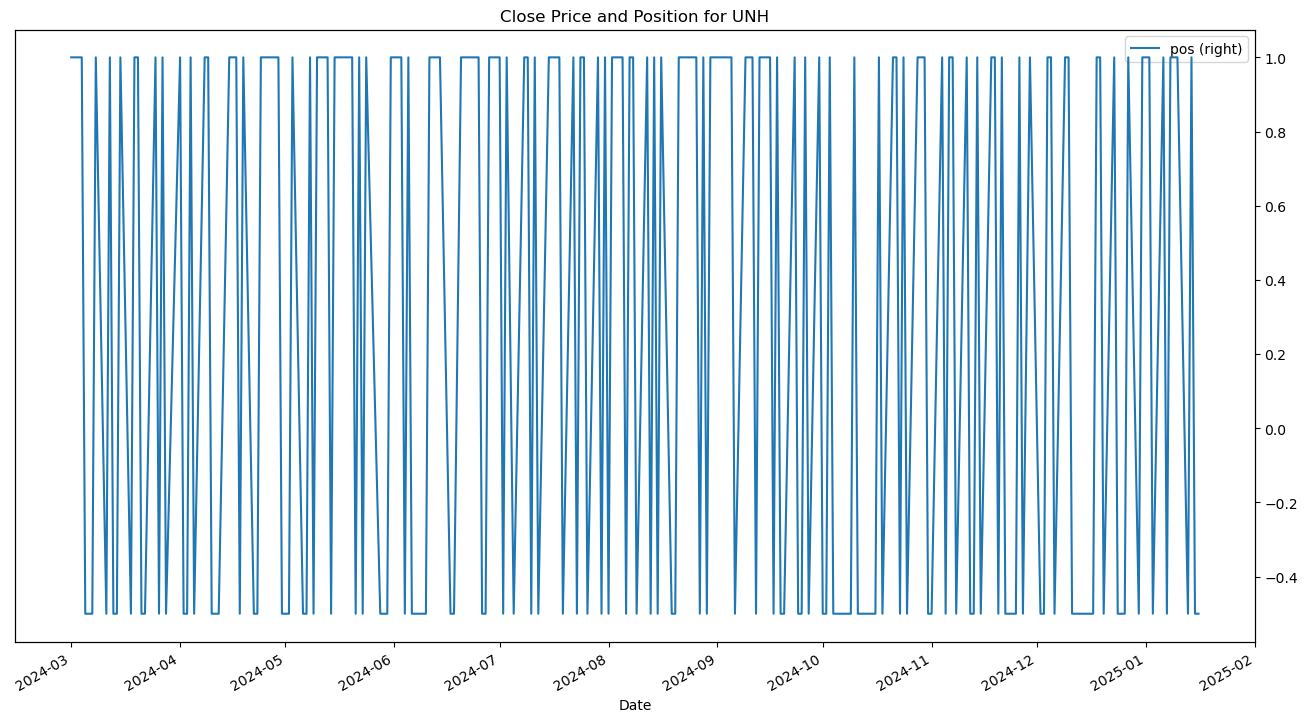

In [13]:
ax = df_result[['pos']].plot(figsize=(16,9), secondary_y='pos')
ax.set_title("Close Price and Position for " + stock)

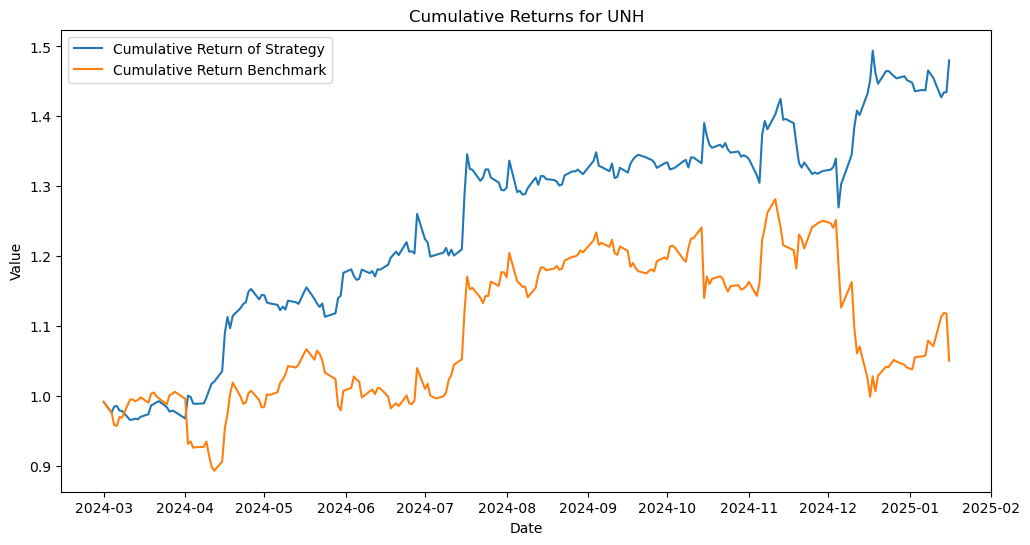

In [14]:
plt.figure(figsize = (12,6))
plt.plot(df_result[['Cumulative_Return_Strategy']], label='Cumulative Return of Strategy')
plt.plot(df_result[['cum_ret_benchmark']], label='Cumulative Return Benchmark')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Cumulative Returns for ' + stock)
plt.legend();